## Introduction  

### Session purpose
In this session, we are introducing gaussian processes for regression applications (GPR). Before diving 
into details about GPR, you should know that gaussian process can also be used for classification 
applications with the same procedure of GPR.

### Learning outcome
After going through this tutorial, you will be able to

1. Handle a tabular dataset with missing values for regression applications;
2. Implement gaussian process for regression applications;
3. Understand the uncertainty of GPR estimation.

## 1 - Review the data

In [1]:
library(dplyr); library(magrittr); 
library(ggplot2); 
library(caret)  ## library for machine learning 
library(psych)  ## library for statistical analysis including factor analysis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




We are using the quality controlled daily station observations from US Climate Reference Network (USCRN). 
In this notebook, we will use the data of Asheville station with nearly 10 years of data. First, let's read 
in the data from the CSV (comma separated variable) file from [our repository](https://github.com/geo-yrao/ML4ES-tutorials/tree/master/00-Data/USCRN-data).

In [2]:
## Define the file name of the CSV file
fname <- "https://raw.githubusercontent.com/geo-yrao/ML4ES-tutorials/master/00-Data/USCRN-data/USCRN-NC_Asheville_8_SSW_2010-2019.csv"

## Read in the RAW daily data
RawData <- read.csv(fname)

## Check the column names of the tabular data
print ( colnames(RawData) )

 [1] "WBANNO"                  "LST_DATE"               
 [3] "CRX_VN"                  "LONGITUDE"              
 [5] "LATITUDE"                "T_DAILY_MAX"            
 [7] "T_DAILY_MIN"             "T_DAILY_MEAN"           
 [9] "T_DAILY_AVG"             "P_DAILY_CALC"           
[11] "SOLARAD_DAILY"           "SUR_TEMP_DAILY_TYPE"    
[13] "SUR_TEMP_DAILY_MAX"      "SUR_TEMP_DAILY_MIN"     
[15] "SUR_TEMP_DAILY_AVG"      "RH_DAILY_MAX"           
[17] "RH_DAILY_MIN"            "RH_DAILY_AVG"           
[19] "SOIL_MOISTURE_5_DAILY"   "SOIL_MOISTURE_10_DAILY" 
[21] "SOIL_MOISTURE_20_DAILY"  "SOIL_MOISTURE_50_DAILY" 
[23] "SOIL_MOISTURE_100_DAILY" "SOIL_TEMP_5_DAILY"      
[25] "SOIL_TEMP_10_DAILY"      "SOIL_TEMP_20_DAILY"     
[27] "SOIL_TEMP_50_DAILY"      "SOIL_TEMP_100_DAILY"    


From the column names, we see that there are 28 different variables in this tabular data.
What does each column means? It is all documented in the [readme file](https://github.com/geo-yrao/ML4ES-tutorials/blob/master/00-Data/USCRN-data/USCRN_Daily_Data_readme.txt).

* _**WBANNO**_: The station WBAN number.
* _**LST_DATE**_: The Local Standard Time (LST) date of the observation (YYYYMMDD).
* _**CRX_VN**_: The version number of the station datalogger program.
* _**LONGITUDE**_: Station longitude, using WGS-84 (unit: decimal_degrees_east).
* _**LATITUDE**_: Station latitude, using WGS-84 (unit: decimal_degrees_north).
* _**T_DAILY_MAX**_: Maximum air temperature (unit: Celsius).
* _**T_DAILY_MIN**_: Minimum air temperature (unit: Celsius).
* _**T_DAILY_MEAN**_: Mean air temperature calculated using maximum and minimum temperature (unit: Celsius).
* _**T_DAILY_AVG**_: Average air temperature calculated using sub-hourly temperature (unit: Celsius).
* _**P_DAILY_CALC**_: Total amount of precipitation (unit: mm).
* _**SOLARAD_DAILY**_: Total solar energy (unit: MJ/m^2^).
* _**SUR_TEMP_DAILY_TYPE**_: Type of infrared surface temperature measurement.
* _**SUR_TEMP_DAILY_MAX**_: Maximum infrared surface temperature(unit: Celsius).
* _**SUR_TEMP_DAILY_MIN**_: Minimum infrared surface temperature (unit: Celsius).
* _**SUR_TEMP_DAILY_AVG**_: Average infrared surface temperature (unit: Celsius).
* _**RH_DAILY_MAX**_: Maximum relative humidity (unit: %).
* _**RH_DAILY_MIN**_: Minimum relative humidity (unit: %).
* _**RH_DAILY_AVG**_: Average relative humidity (unit: %).
* _**SOIL_MOISTURE_5_DAILY**_: Average soil moisture at 5 cm below the surface (unit: m^3^/m^3^).
* _**SOIL_MOISTURE_10_DAILY**_: Average soil moisture at 10 cm below the surface (unit: m^3^/m^3^).
* _**SOIL_MOISTURE_20_DAILY**_: Average soil moisture at 20 cm below the surface (unit: m^3^/m^3^).
* _**SOIL_MOISTURE_50_DAILY**_: Average soil moisture at 50 cm below the surface (unit: m^3^/m^3^).
* _**SOIL_MOISTURE_100_DAILY**_: Average soil moisture at 100 cm below the surface (unit: m^3^/m^3^).
* _**SOIL_TEMP_5_DAILY**_: Average soil temperature at 5 cm below the surface (unit: Celsius).
* _**SOIL_TEMP_10_DAILY**_: Average soil temperature at 10 cm below the surface (unit: Celsius).
* _**SOIL_TEMP_20_DAILY**_: Average soil temperature at 20 cm below the surface (unit: Celsius).
* _**SOIL_TEMP_50_DAILY**_: Average soil temperature at 50 cm below the surface (unit: Celsius).
* _**SOIL_TEMP_100_DAILY**_: Average soil temperature at 100 cm below the surface (unit: Celsius).

Assuming our target is to identify the factors that can be used to estimate soil moisture & temperature, so we will only keep the other meteorological variables for our principal component analysis & factor analysis.

In [3]:
### we only keep part of the variables for the application.
## In addition to the input variables, we kept date to help us separate the data for training/testing
SlimData <- RawData %>% select ( c(6:11, 13:18) )

## Check the first & last 10 rows of the data
head(SlimData, 10) 
tail(SlimData, 10)

,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,SOLARAD_DAILY,SUR_TEMP_DAILY_MAX,SUR_TEMP_DAILY_MIN,SUR_TEMP_DAILY_AVG,RH_DAILY_MAX,RH_DAILY_MIN,RH_DAILY_AVG
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.3,-6.2,-1.0,0.6,0,7.54,18.0,-6.3,1.4,98.4,45.8,73.8
2,-5.1,-10.2,-7.6,-7.1,0,8.07,7.3,-9.6,-5.4,79.4,44.2,59.3
3,-5.3,-11.6,-8.4,-9.2,0,5.16,15.6,-10.7,-7.7,70.1,39.1,54.9
4,-4.4,-11.6,-8.0,-8.1,0,9.30,14.6,-11.2,-5.9,76.0,50.9,62.3
5,-3.2,-9.8,-6.5,-6.9,0,7.54,13.3,-9.5,-5.3,81.5,54.4,67.1
6,-1.0,-9.4,-5.2,-5.8,0,9.24,13.1,-10.3,-4.7,82.6,49.2,67.9
7,4.2,-9.1,-2.4,-2.5,0,5.68,16.2,-8.9,-1.2,87.1,25.1,64.9
8,-2.0,-12.6,-7.3,-9.1,0,8.79,20.9,-11.7,-7.0,82.4,53.5,66.3
9,-3.0,-12.3,-7.7,-8.0,0,8.73,26.1,-11.7,-5.9,82.4,41.0,62.0


,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,SOLARAD_DAILY,SUR_TEMP_DAILY_MAX,SUR_TEMP_DAILY_MIN,SUR_TEMP_DAILY_AVG,RH_DAILY_MAX,RH_DAILY_MIN,RH_DAILY_AVG
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3643,5.8,-0.7,2.6,3.1,13.3,0.96,6.5,-2.0,2.9,98.8,68.2,91.3
3644,11.0,5.3,8.2,8.3,12.4,0.96,10.6,5.1,7.7,98.8,85.9,97.6
3645,17.8,1.6,9.7,8.9,0.0,8.00,19.6,-0.6,7.4,99.3,44.7,90.4
3646,16.2,-1.8,7.2,5.0,0.0,7.49,19.4,-3.4,3.5,99.2,46.8,84.4
3647,19.1,-2.1,8.5,5.4,0.0,8.12,20.1,-3.7,3.5,98.8,26.4,80.8
3648,17.0,-1.7,7.6,6.2,0.0,5.85,19.7,-3.1,4.8,98.2,39.7,82.5
3649,18.1,0.4,9.3,9.6,1.0,6.67,20.6,-1.0,7.7,98.3,50.8,81.0
3650,17.4,12.3,14.8,15.0,13.5,2.19,17.8,10.7,13.6,97.3,84.3,93.7
3651,18.2,0.6,9.4,11.5,1.2,8.52,18.9,-1.1,9.1,96.8,22.2,69.9


We can see that there are missing values in the current data set. Let's see how many missing values exist in the current data set.  

In [4]:
## Summarize the missing value
missingSum <- SlimData %>% 
  select_if(function(x) any(is.na(x))) %>%           ## Check if the column contains missing value
  summarise_all(funs(sum(is.na(.)/length(.)*100)))   ## if so, then count what percent of the data is missing

print("Percentage of missing values in each variable")
missingSum %>% knitr::kable()

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


[1] "Percentage of missing values in each variable"




| T_DAILY_MAX| T_DAILY_MIN| T_DAILY_MEAN| T_DAILY_AVG| P_DAILY_CALC| SOLARAD_DAILY| SUR_TEMP_DAILY_MAX| SUR_TEMP_DAILY_MIN| SUR_TEMP_DAILY_AVG| RH_DAILY_MAX| RH_DAILY_MIN| RH_DAILY_AVG|
|-----------:|-----------:|------------:|-----------:|------------:|-------------:|------------------:|------------------:|------------------:|------------:|------------:|------------:|
|   0.4654984|   0.4654984|    0.4654984|   0.4928806|     1.040526|     0.4654984|          0.4654984|          0.4654984|          0.4654984|    0.4654984|    0.4654984|    0.4654984|

It appears that there is <1% of data records has missing value for the data. To proceed with 
model development, we will only keep the complete daily data records in this notebook. In the future, 
we will introduce how to impute missing values for more complex model development.  

In [5]:
CleanData <- SlimData %>% tidyr::drop_na() #drop_na() removes rows with missing values for any columns

str(CleanData)

'data.frame':	3613 obs. of  12 variables:
 $ T_DAILY_MAX       : num  4.3 -5.1 -5.3 -4.4 -3.2 -1 4.2 -2 -3 -1.4 ...
 $ T_DAILY_MIN       : num  -6.2 -10.2 -11.6 -11.6 -9.8 -9.4 -9.1 -12.6 -12.3 -12.3 ...
 $ T_DAILY_MEAN      : num  -1 -7.6 -8.4 -8 -6.5 -5.2 -2.4 -7.3 -7.7 -6.9 ...
 $ T_DAILY_AVG       : num  0.6 -7.1 -9.2 -8.1 -6.9 -5.8 -2.5 -9.1 -8 -6.9 ...
 $ P_DAILY_CALC      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ SOLARAD_DAILY     : num  7.54 8.07 5.16 9.3 7.54 9.24 5.68 8.79 8.73 9.71 ...
 $ SUR_TEMP_DAILY_MAX: num  18 7.3 15.6 14.6 13.3 13.1 16.2 20.9 26.1 14.4 ...
 $ SUR_TEMP_DAILY_MIN: num  -6.3 -9.6 -10.7 -11.2 -9.5 -10.3 -8.9 -11.7 -11.7 -11.7 ...
 $ SUR_TEMP_DAILY_AVG: num  1.4 -5.4 -7.7 -5.9 -5.3 -4.7 -1.2 -7 -5.9 -5 ...
 $ RH_DAILY_MAX      : num  98.4 79.4 70.1 76 81.5 82.6 87.1 82.4 82.4 88 ...
 $ RH_DAILY_MIN      : num  45.8 44.2 39.1 50.9 54.4 49.2 25.1 53.5 41 36 ...
 $ RH_DAILY_AVG      : num  73.8 59.3 54.9 62.3 67.1 67.9 64.9 66.3 62 59.5 ...


## 2 - Principal Component Analysis

In this section, we explore how we can perform principal component analysis to decompose our data set into orthongonal
components and explore how to select number of principal components. 

Before we perform PCA, let's first examine the correlation matrix between these variables to see what's the benefit of PCA.

In [6]:
## calculate correlation matrix (covariance matrix)
cor_matrix <- cor(CleanData);

## Reshape the data into long format for plotting
cor_dataframe <- reshape2::melt(cor_matrix); str(cor_dataframe)

'data.frame':	144 obs. of  3 variables:
 $ Var1 : Factor w/ 12 levels "T_DAILY_MAX",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Var2 : Factor w/ 12 levels "T_DAILY_MAX",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ value: num  1 0.84 0.96 0.95 -0.035 ...


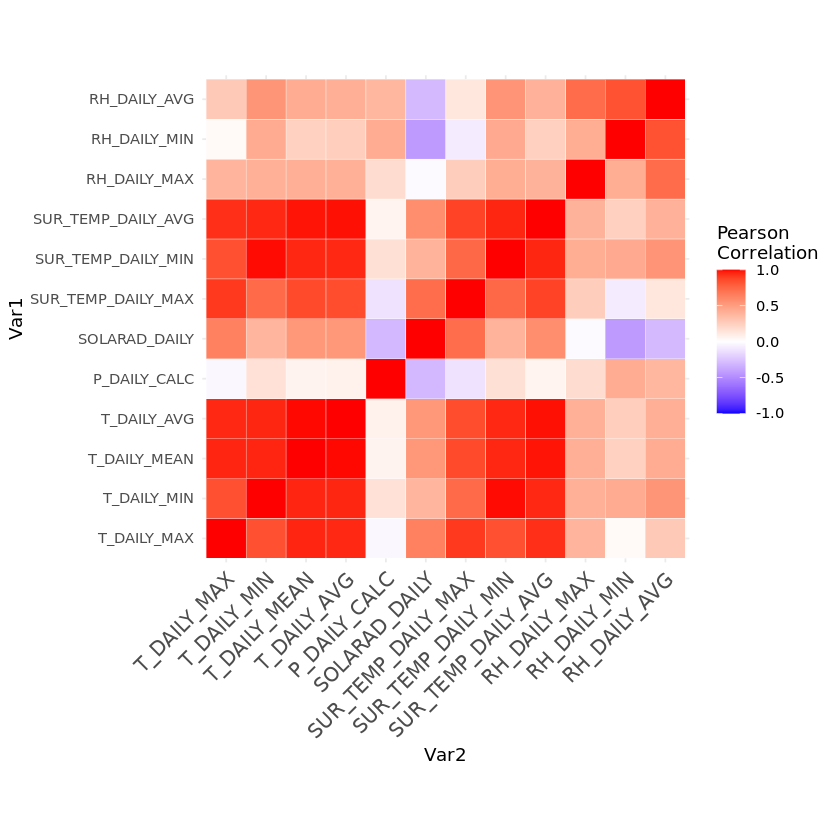

In [7]:
## Using ggplot2 to plot correlation matrix
cor_dataframe %>% ggplot( aes(Var2, Var1, fill = value) ) +
     geom_tile(color = "white")+
     scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
       midpoint = 0, limit = c(-1,1), space = "Lab", 
       name="Pearson\nCorrelation") +
     theme_minimal()+ 
     theme(axis.text.x = element_text(angle = 45, vjust = 1, 
           size = 12, hjust = 1))+
     coord_fixed()

Although it is unlikely that in our application we will intentionally put all daily temperature varibales (max, min, mean, avg) into our model development, this correlation matrix still gives us an extreme example of how high dimensional input data can be problematic for model development with strong correlation between different variables. So now let's see how PCA and other methods can help address this issue.

In [8]:
## Performing PCA analysis using prcomp with centering and scaling of the data
pca_results <- princomp(CleanData, cor=TRUE)

## check the pca results
summary(pca_results)

Importance of components:
                          Comp.1    Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     2.6983808 1.6665900 0.90093635 0.77272162 0.48798989
Proportion of Variance 0.6067716 0.2314602 0.06764052 0.04975823 0.01984451
Cumulative Proportion  0.6067716 0.8382318 0.90587228 0.95563050 0.97547502
                           Comp.6      Comp.7      Comp.8      Comp.9
Standard deviation     0.36410766 0.284370081 0.241684977 0.110930915
Proportion of Variance 0.01104787 0.006738862 0.004867636 0.001025472
Cumulative Proportion  0.98652288 0.993261743 0.998129378 0.999154851
                            Comp.10      Comp.11      Comp.12
Standard deviation     0.0901833911 0.0446867025 3.442063e-03
Proportion of Variance 0.0006777537 0.0001664084 9.873166e-07
Cumulative Proportion  0.9998326042 0.9999990127 1.000000e+00

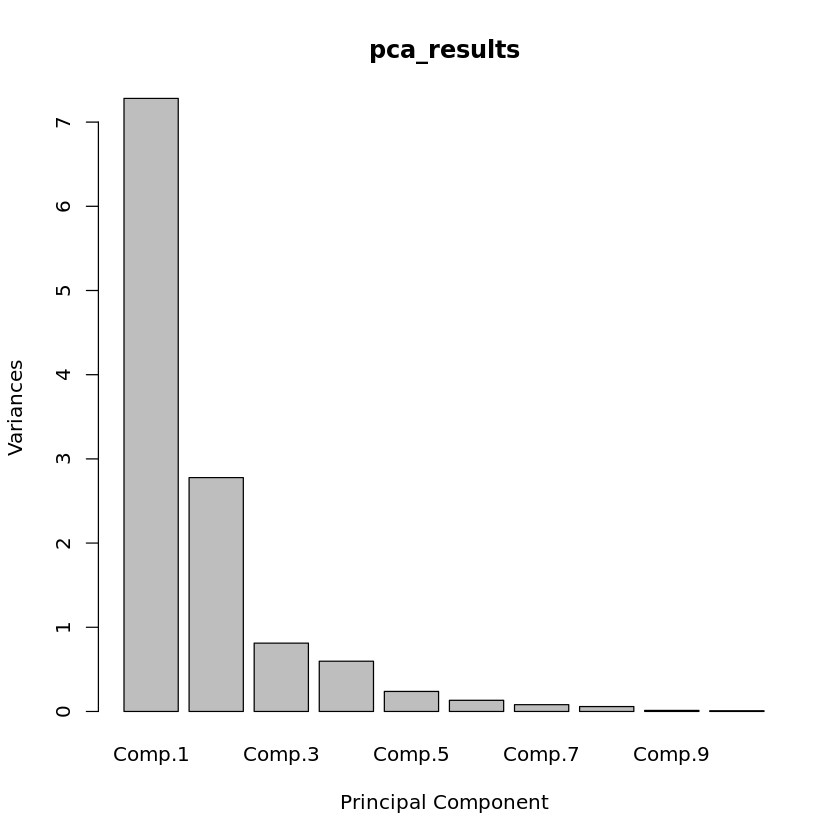

In [9]:
plot(pca_results, xlab = "Principal Component")

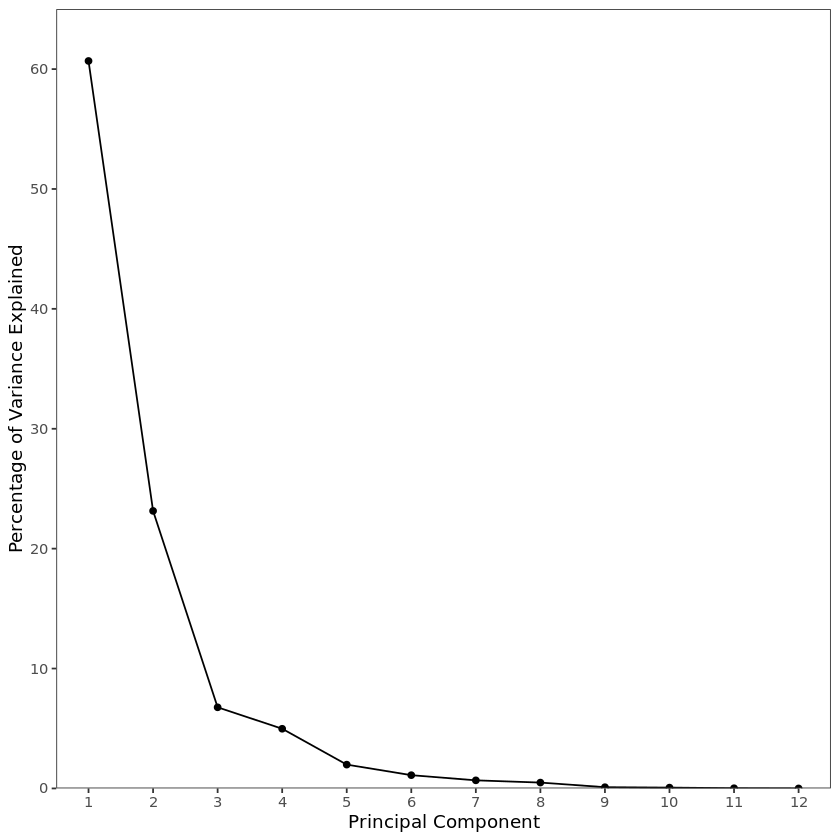

In [10]:
## Calculation percentage of variance explained from the results
var_explained <- pca_results$sdev^2 / sum(pca_results$sdev^2) * 100

## Plot percentage of var explained for each PC
qplot(c(1:12), var_explained) +
    geom_line() +
    scale_x_continuous(breaks = seq(1,12), name = "Principal Component") +
    scale_y_continuous(breaks = seq(0,65,10), name = "Percentage of Variance Explained") +
    theme_bw() + coord_cartesian(xlim = c(0.5,12.5), ylim = c(0, 65), expand = F) +
    theme(panel.grid = element_blank())

Based on the percentage of variance explained, we see that more than 90% of the variances are explained by the first three principal components, so it means that they are likely enough to represent the majority of the information. But how does these three components relates to our original variables? We can check the loadings of the analysis.

In [11]:
## Check the loadings of all the components from PCA results
## loadings directly provides the value for each component
loadings(pca_results)


Loadings:
                   Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8
T_DAILY_MAX         0.347  0.151         0.124  0.287  0.115  0.355  0.526
T_DAILY_MIN         0.357        -0.115 -0.215        -0.312        -0.304
T_DAILY_MEAN        0.367                       0.167 -0.102  0.141  0.118
T_DAILY_AVG         0.366                       0.120 -0.163         0.280
P_DAILY_CALC              -0.358 -0.734  0.574                            
SOLARAD_DAILY       0.193  0.440         0.223 -0.811         0.218       
SUR_TEMP_DAILY_MAX  0.318  0.241         0.117         0.766 -0.367 -0.246
SUR_TEMP_DAILY_MIN  0.358        -0.112 -0.195        -0.259 -0.126 -0.380
SUR_TEMP_DAILY_AVG  0.366                                    -0.146       
RH_DAILY_MAX        0.183 -0.295  0.601  0.587        -0.237 -0.336       
RH_DAILY_MIN        0.117 -0.514        -0.394 -0.448  0.222 -0.284  0.464
RH_DAILY_AVG        0.187 -0.480  0.252                0.294  0.658 -0.341
              

From the loading data, we can see that daily temperature variables from both surface and near-surface contributes nearly equaly for the first component while second component have strong contribution from precipitation, humidity and radiation which is all related to the moisture. As you can see, interpreting the PCA results are more or less an art to find the commonalities in those variables have strongest contributions to the component.

## 3 - Factor Analysis

[Factor analysis](https://en.wikipedia.org/wiki/Factor_analysis) is a type of method to extract potential latent variables (factors) from the observed variables. Different from PCA, factor analysis only focuses on the "*common variance*" of all variables instead of the total variances. We will use _**pysch**_ library to perform the factor analysis can also compare with the PCA results.

Warning message in cor.smooth(model):
“Matrix was not positive definite, smoothing was done”
Warning message in fa.stats(r = r, f = f, phi = phi, n.obs = n.obs, np.obs = np.obs, :
“The estimated weights for the factor scores are probably incorrect.  Try a different factor score estimation method.”
Warning message in fac(r = r, nfactors = nfactors, n.obs = n.obs, rotate = rotate, :
“An ultra-Heywood case was detected.  Examine the results carefully”


Parallel analysis suggests that the number of factors =  3  and the number of components =  NA 


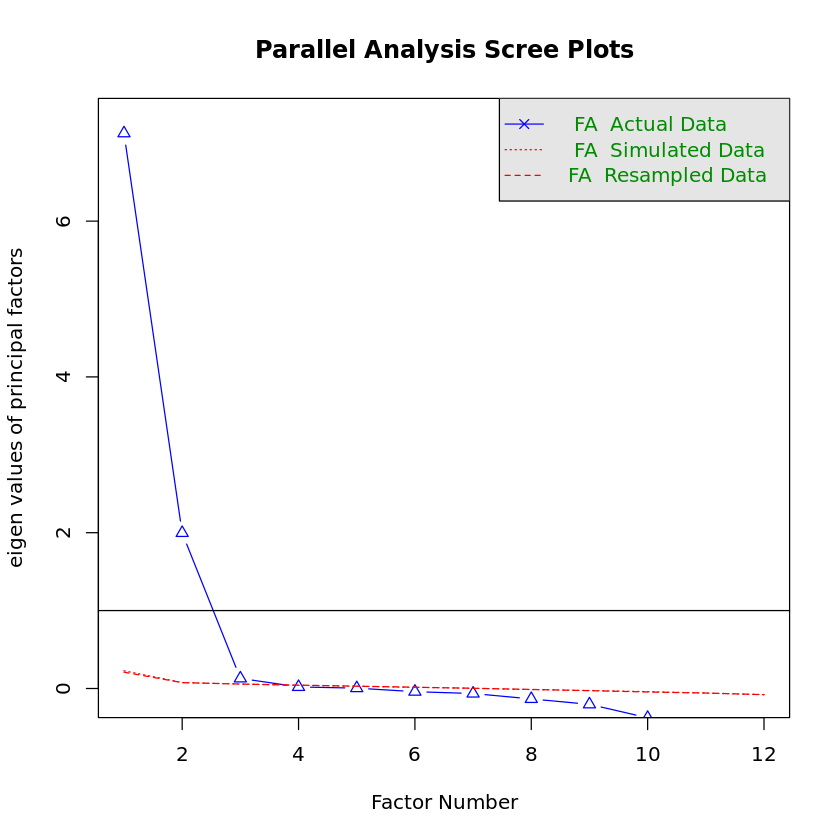

In [12]:
## pysch::fa.parallel() function provides a comprehensive function to perform FA and determine how many factors to retain
fa_results <- psych::fa.parallel(CleanData, fm = "pa", fa = "fa")

The *psych::fa.parallel()* automatially generates the scree plot for the factor analysis to assist the decision on how many factors to retain and the plot show that we should retain three factors as the result of the parallel analysis.

In addition, the function also allows the comparison between PCA and factor analysis directly by simply changing one key word *fa=...* from _"fa"_ to _"both"*_.

Warning message in cor.smooth(model):
“Matrix was not positive definite, smoothing was done”
Warning message in fa.stats(r = r, f = f, phi = phi, n.obs = n.obs, np.obs = np.obs, :
“The estimated weights for the factor scores are probably incorrect.  Try a different factor score estimation method.”
Warning message in fac(r = r, nfactors = nfactors, n.obs = n.obs, rotate = rotate, :
“An ultra-Heywood case was detected.  Examine the results carefully”


Parallel analysis suggests that the number of factors =  3  and the number of components =  2 


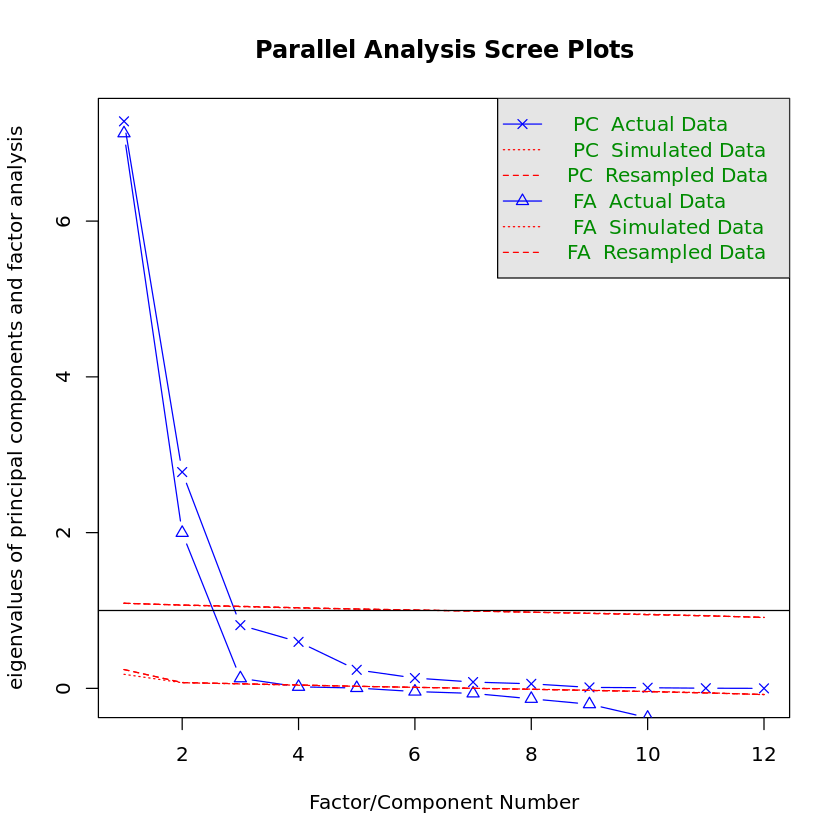

In [13]:
## pysch::fa.parallel() function provides a comprehensive function to perform FA and determine how many factors to retain
fa_results <- psych::fa.parallel(CleanData, fm = "pa", fa = "both")

As marked in the same parallel analysis scree plot, the PCA results should only retain two components while the factor analysis retains three factors. Additionally, the factor analysis eigenvalues are slightly smaller than the PCA results. Thi is normal as factor analysis only focus on common variances while the PCA use total variances for its analysis. 

In [16]:
## based on the parallel analysis, we will carry out the factor analysis specifying 
## only retaining three factors and examine the factor loadings of each variable for
## these three factors
fa_three <- fa(CleanData, fm = "pa", 3);
fa_three

Loading required namespace: GPArotation

Warning message in fac(r = r, nfactors = nfactors, n.obs = n.obs, rotate = rotate, :
“I am sorry, to do these rotations requires the GPArotation package to be installed”
Warning message in fa.stats(r = r, f = f, phi = phi, n.obs = n.obs, np.obs = np.obs, :
“The estimated weights for the factor scores are probably incorrect.  Try a different factor score estimation method.”


Factor Analysis using method =  pa
Call: fa(r = CleanData, nfactors = 3, fm = "pa")
Standardized loadings (pattern matrix) based upon correlation matrix
                    PA1   PA2   PA3   h2     u2 com
T_DAILY_MAX        0.93 -0.26  0.12 0.95 0.0461 1.2
T_DAILY_MIN        0.96  0.12 -0.20 0.98 0.0179 1.1
T_DAILY_MEAN       0.99 -0.07 -0.04 0.99 0.0086 1.0
T_DAILY_AVG        0.99 -0.07 -0.06 0.99 0.0129 1.0
P_DAILY_CALC       0.09  0.45 -0.13 0.23 0.7737 1.3
SOLARAD_DAILY      0.50 -0.69  0.10 0.74 0.2559 1.9
SUR_TEMP_DAILY_MAX 0.85 -0.40  0.10 0.89 0.1108 1.5
SUR_TEMP_DAILY_MIN 0.97  0.12 -0.19 0.98 0.0178 1.1
SUR_TEMP_DAILY_AVG 0.99 -0.10 -0.06 0.99 0.0057 1.0
RH_DAILY_MAX       0.48  0.46  0.52 0.71 0.2899 3.0
RH_DAILY_MIN       0.31  0.85 -0.20 0.86 0.1421 1.4
RH_DAILY_AVG       0.50  0.83  0.20 0.97 0.0251 1.8

                       PA1  PA2  PA3
SS loadings           7.23 2.57 0.49
Proportion Var        0.60 0.21 0.04
Cumulative Var        0.60 0.82 0.86
Proportion Explained  

As shown in the factor analysis results, we observe similar loadings from the factor analysis with the loadings from PCA result. But in this factor analysis result, the facotrs are more "concentrated" in a way with amplified loading values than PCA. The interpretation is also subjective like PCA where users still need to apply domain knowledge to explain what these factors are mostly related to, e.g., heat for PA1, moisture for PA2, and peak humidity for PA3. 